In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from statsmodels.regression import linear_model
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor

In [3]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [4]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, recall_score, confusion_matrix

In [5]:
import dill

In [ ]:
# Saving the Notebook Session
# dill.dump_session('notebook_env.db')

In [ ]:
# Load the Notebook Session
# dill.load_session('notebook_env.db')

# 1. EDA

## 1.1 Load Data and Retrieve Sample

In [6]:
FILE_NAME = 'DSI_kickstarterscrape_dataset.csv'
df = pd.read_csv(FILE_NAME, sep=',', engine='python')

In [7]:
df.columns

Index(['project id', 'name', 'url', 'category', 'subcategory', 'location',
       'status', 'goal', 'pledged', 'funded percentage', 'backers',
       'funded date', 'levels', 'reward levels', 'updates', 'comments',
       'duration'],
      dtype='object')

In [8]:
df.sample(3).T

,21425,9251,45081
project id,1007813578,438323575,2114610106
name,NEW Album - Sit at the Feet of Jesus,BOUNCE QUEEN,Open-Source High-Performance Electric Vehicle
url,http://www.kickstarter.com/projects/971541660/...,http://www.kickstarter.com/projects/803779768/...,http://www.kickstarter.com/projects/981348905/...
category,Music,Film &amp; Video,Technology
subcategory,Country &amp; Folk,Documentary,Open Hardware
location,"Lawrence, KS","New Orleans, LA","Chico, CA"
status,successful,failed,failed
goal,2300,30000,8000
pledged,2916,1471,391
funded percentage,1.26783,0.0490333,0.0488463


## 1.2 Data Cleaning

In [9]:
# Check for null values
df.isna().sum()

project id              0
name                    0
url                     0
category                0
subcategory             0
location             1322
status                  0
goal                    0
pledged                12
funded percentage       0
backers                 0
funded date             0
levels                  0
reward levels          59
updates                 0
comments                0
duration                0
dtype: int64

In [10]:
# Drop the null values (for now)
df.dropna(axis=0, how='any', inplace=True)

In [11]:
# Check Data Types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44580 entries, 0 to 45956
Data columns (total 17 columns):
project id           44580 non-null int64
name                 44580 non-null object
url                  44580 non-null object
category             44580 non-null object
subcategory          44580 non-null object
location             44580 non-null object
status               44580 non-null object
goal                 44580 non-null float64
pledged              44580 non-null float64
funded percentage    44580 non-null float64
backers              44580 non-null int64
funded date          44580 non-null object
levels               44580 non-null int64
reward levels        44580 non-null object
updates              44580 non-null int64
comments             44580 non-null int64
duration             44580 non-null float64
dtypes: float64(4), int64(5), object(8)
memory usage: 6.1+ MB


In [12]:
# Round Off Amounts and Time and convert to int
# Funded Percentage will be ignored for now as it will be discarded later
df['goal'] = df['goal'].round().astype(int)
df['pledged'] = df['pledged'].round().astype(int)
df['duration'] = df['duration'].round().astype(int)

## 1.3 Status - Target Variable

In [13]:
# Check the Target Variable
df['status'].value_counts()

successful    22322
failed        18278
live           3917
canceled         59
suspended         4
Name: status, dtype: int64

In [14]:
# We do not need live, canceled or suspended
# Just take successful or failed
df = df[df['status'].isin(['successful', 'failed'])]

In [15]:
df.shape

(40600, 17)

In [16]:
# Check the Other Target Variable
df['pledged'].describe()

count    4.060000e+04
mean     5.207846e+03
std      6.005238e+04
min      0.000000e+00
25%      2.300000e+02
50%      1.482500e+03
75%      4.457000e+03
max      1.026684e+07
Name: pledged, dtype: float64

In [17]:
# Some pledged values are 0, need to check these records
df[df['pledged'] == 0]

,project id,name,url,category,subcategory,location,status,goal,pledged,funded percentage,backers,funded date,levels,reward levels,updates,comments,duration
4,246101,The Launch of FlyeGrlRoyalty &quot;The New Nam...,http://www.kickstarter.com/projects/flyegrlroy...,Fashion,Fashion,"Novi, MI",failed,3500,0,0.0,0,"Wed, 01 Jun 2011 15:25:39 -0000",6,"$10,$25,$50,$100,$150,$250",2,0,30
16,1057236,The Life and Adventures of Sue Bee,http://www.kickstarter.com/projects/2054420885...,Publishing,Nonfiction,"Washington, DC",failed,25000,0,0.0,0,"Sat, 24 Mar 2012 23:31:04 -0000",4,"$10,$25,$50,$250",0,0,30
47,2353033,&quot;Chased Resignation&quot;,http://www.kickstarter.com/projects/chasedresi...,Film & Video,Film &amp; Video,"Arcadia, CA",failed,20000,0,0.0,0,"Tue, 26 Jul 2011 04:00:00 -0000",3,"$20,$100,$1,000",0,0,63
72,3584870,Unlimited Wear Clothing,http://www.kickstarter.com/projects/621865472/...,Fashion,Fashion,"Azusa, CA",failed,2000,0,0.0,0,"Sun, 04 Dec 2011 13:17:00 -0000",3,"$1,$25,$100",0,0,26
73,3656699,"Time, Space and Bullets! board game",http://www.kickstarter.com/projects/TimPark/ti...,Games,Board & Card Games,"San Rafael, CA",failed,7500,0,0.0,0,"Mon, 01 Nov 2010 20:06:08 -0000",5,"$15,$25,$50,$100,$500",0,0,60
76,3777457,HAPPY AS A CLAM,http://www.kickstarter.com/projects/1114111720...,Food,Food,"St Augustine, FL",failed,80000,0,0.0,0,"Tue, 07 Feb 2012 00:09:05 -0000",7,"$25,$50,$100,$500,$1,000,$5,000,$7,500",0,0,60
82,4006477,Imperial Clothes,http://www.kickstarter.com/projects/imperialcc...,Fashion,Fashion,"Brooklyn, NY",failed,5000,0,0.0,0,"Wed, 01 Feb 2012 19:18:00 -0000",4,"$50,$100,$500,$1,000",2,0,60
83,4070527,TOMATOCLAM et al,http://www.kickstarter.com/projects/1795134881...,Food,Food,"Virginia Beach, VA",failed,100000,0,0.0,0,"Tue, 07 Feb 2012 21:42:28 -0000",2,"$50,$50",0,0,45
87,4173934,Pour some sugar on us.,http://www.kickstarter.com/projects/1936435841...,Music,Rock,"Tucson, AZ",failed,2500,0,0.0,0,"Fri, 02 Dec 2011 06:34:31 -0000",3,"$5,$25,$100",0,0,60
88,4290744,Sturgis Rally Yearbook,http://www.kickstarter.com/projects/verberastu...,Photography,Photography,"Los Angeles, CA",failed,10000,0,0.0,0,"Wed, 20 Jul 2011 07:00:00 -0000",9,"$5,$10,$20,$30,$40,$50,$100,$500,$5,000",0,0,72


## 1.4 Category

In [18]:
df['category'].value_counts()

Film &amp; Video    11686
Music                9811
Publishing           3970
Art                  3571
Theater              2281
Design               1536
Games                1418
Photography          1297
Food                 1270
Fashion              1000
Comics                930
Technology            700
Dance                 690
Film & Video          440
Name: category, dtype: int64

In [19]:
# Fix the Film &amp; Video category and merge with Film & Video
df['category'].replace(to_replace='&amp;', value='&', inplace=True, regex=True)

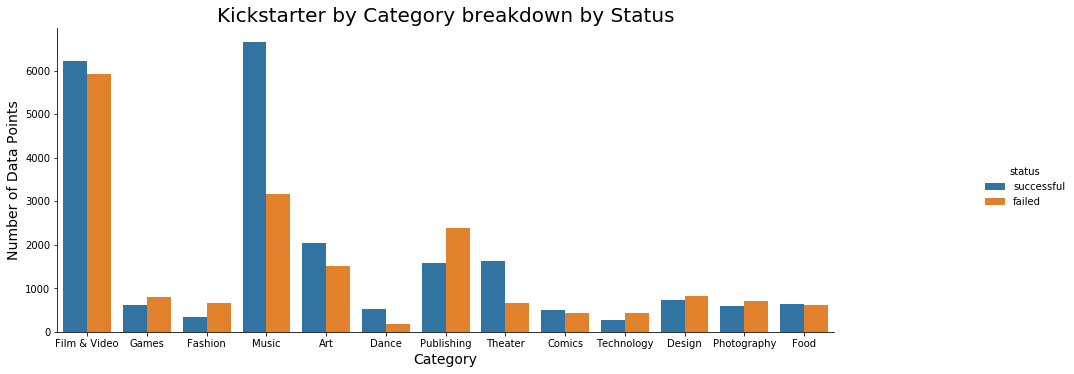

In [20]:
g = sns.catplot(x='category', hue='status', kind='count', data=df)
g.fig.set_size_inches(16, 5)

g.ax.set_title('Kickstarter by Category breakdown by Status', fontsize=20)
g.set_xlabels('Category', fontsize=14)
g.set_ylabels('Number of Data Points', fontsize=14)

## 1.5 SubCategory

In [21]:
df['subcategory'].value_counts()

Short Film                3646
Documentary               3477
Music                     2950
Theater                   2281
Film &amp; Video          2278
Indie Rock                1757
Rock                      1608
Narrative Film            1366
Photography               1297
Food                      1270
Webseries                 1000
Fashion                   1000
Art                        971
Comics                     930
Fiction                    904
Product Design             899
Nonfiction                 840
Country &amp; Folk         728
Video Games                723
Dance                      690
Pop                        675
Publishing                 595
Children's Book            529
Public Art                 508
Painting                   457
Performance Art            447
Classical Music            419
Hip-Hop                    411
Mixed Media                408
Jazz                       399
Board &amp; Card Games     369
World Music                367
Animatio

In [22]:
# Replace &amp with &
df['subcategory'].replace(to_replace='&amp;', value='&', inplace=True, regex=True)

In [23]:
df_subcategory = df.groupby(by=['category', 'subcategory', 'status']).agg({'subcategory':'count'})
df_subcategory.columns = ['count']
df_subcategory.reset_index(inplace = True)

(0.0, 1.0, 0.0, 1.0)

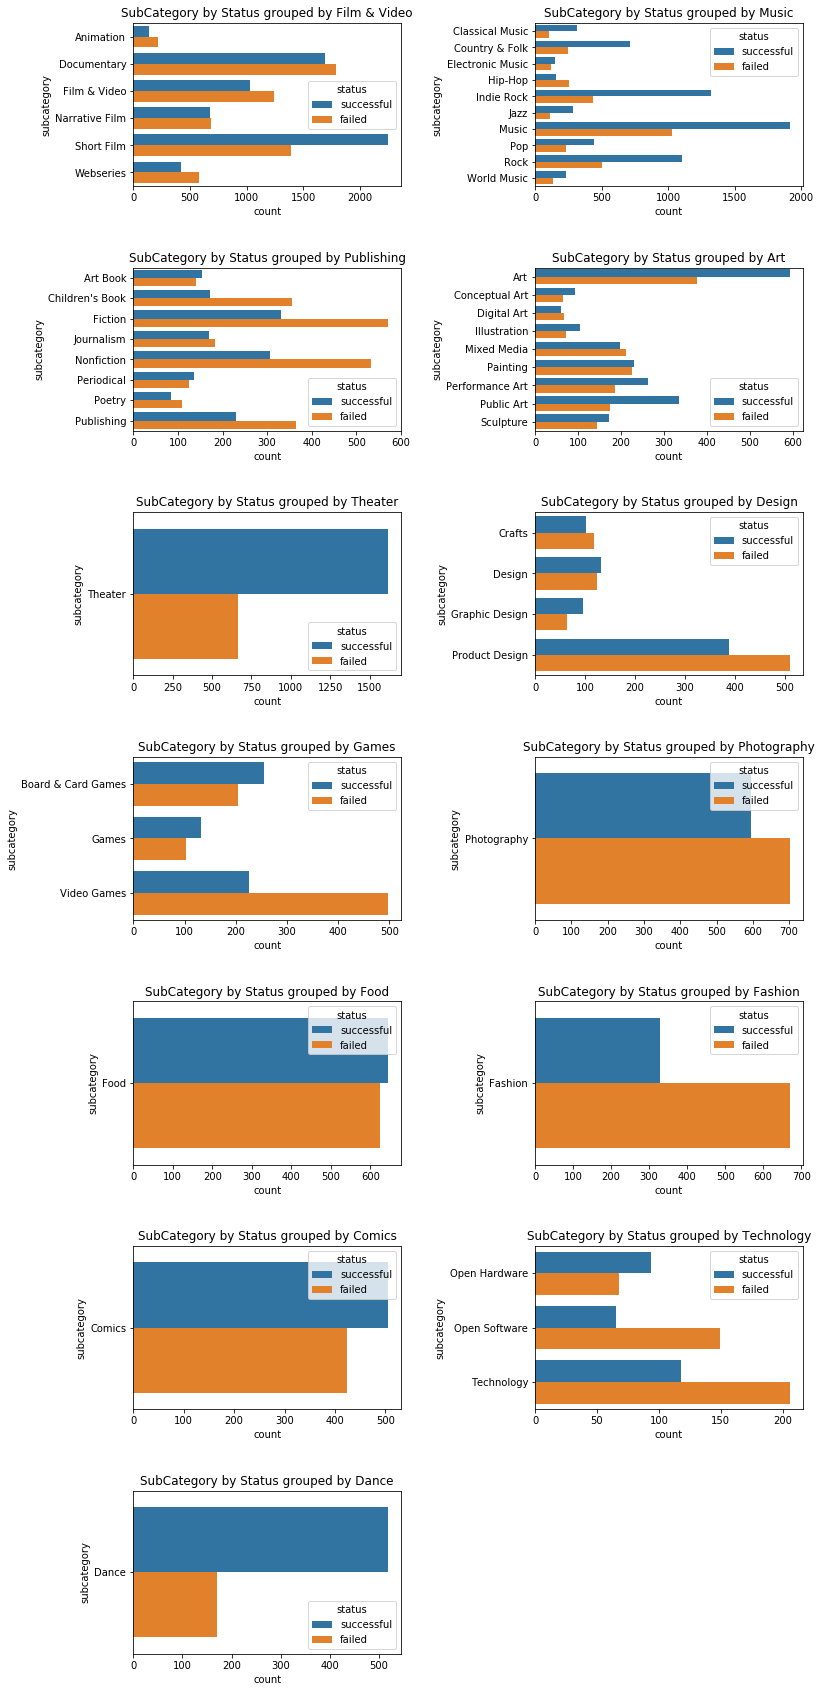

In [24]:
CATEGORIES = df['category'].value_counts().index.tolist()
NO_CATEGORIES = len(CATEGORIES)

COLS = 2
ROWS = int((NO_CATEGORIES + (COLS - NO_CATEGORIES % COLS)) / COLS)

fig, ax = plt.subplots(ROWS, COLS, figsize = (12, 30))
fig.subplots_adjust(wspace=0.5, hspace=0.5)

for index, category in enumerate(CATEGORIES):
    CURR_COL = int(index % COLS)
    CURR_ROW = int((index + (COLS - index % COLS)) / COLS) - 1
    
    DATA = df_subcategory[df_subcategory['category'] == category]
    HUE_ORDER = ['successful', 'failed']
    
    sns.barplot(x='count', y='subcategory', hue='status', hue_order=HUE_ORDER, data=DATA, ax=ax[CURR_ROW][CURR_COL])
    ax[CURR_ROW][CURR_COL].set_title('SubCategory by Status grouped by {}'.format(category))
    
ax[-1, -1].axis('off')

## 1.6 Location - Drop and Introduce new features (State and Country) and remove non-US countries afterwards

In [25]:
STATES = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

In [37]:
def get_state(string):
    return string.split(',')[-1].strip()

def get_country(string):
    if string.split(',')[-1].strip() in STATES:
        return 'US'
    else:
        return 'Non-US'

In [38]:
df['state'] = df['location'].apply(lambda x: get_state(x))
df['country'] = df['location'].apply(lambda x: get_country(x))

In [39]:
# Only consider projects inside the US to avoid other unknown factors that can influence project success
df = df[df['country'] == 'US']
df.drop(axis=1, columns=['location'], inplace=True)

/home/neil/anaconda3/envs/Luumit/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [40]:
df[['state', 'country']].sample(10)

,state,country
17228,IN,US
16963,CO,US
34304,OH,US
43402,WA,US
3622,NY,US
27830,OR,US
8757,MD,US
31107,CA,US
33564,TX,US
25110,CA,US


In [41]:
df.shape

(38463, 18)

In [42]:
df_state = df.groupby(['state', 'status']).agg({'state':'count', 'goal':'sum', 'pledged':'sum'})
df_state.columns = ['count', 'goal', 'pledged']
df_state.reset_index(inplace = True)

In [43]:
df_state['goal_l'] = np.log10(df_state['goal'])
df_state['pledged_l'] = np.log10(df_state['pledged'])

In [44]:
df_state.sample(10)

,state,status,count,goal,pledged,goal_l,pledged_l
38,MA,failed,448,5529505,375746,6.742686,5.574894
6,AZ,failed,320,5439756,220903,6.735579,5.344202
79,RI,successful,123,506628,659852,5.704689,5.819447
54,NC,failed,373,3924325,240577,6.593765,5.381254
21,GA,successful,415,1959056,3735882,6.292047,6.572393
24,IA,failed,81,867012,56135,5.938025,4.749234
77,PA,successful,680,3184646,5620760,6.503061,6.749795
90,VA,failed,229,2728205,184833,6.435877,5.266780
55,NC,successful,377,1958710,2461458,6.291970,6.391192
97,WI,successful,174,686106,893739,5.836391,5.951211


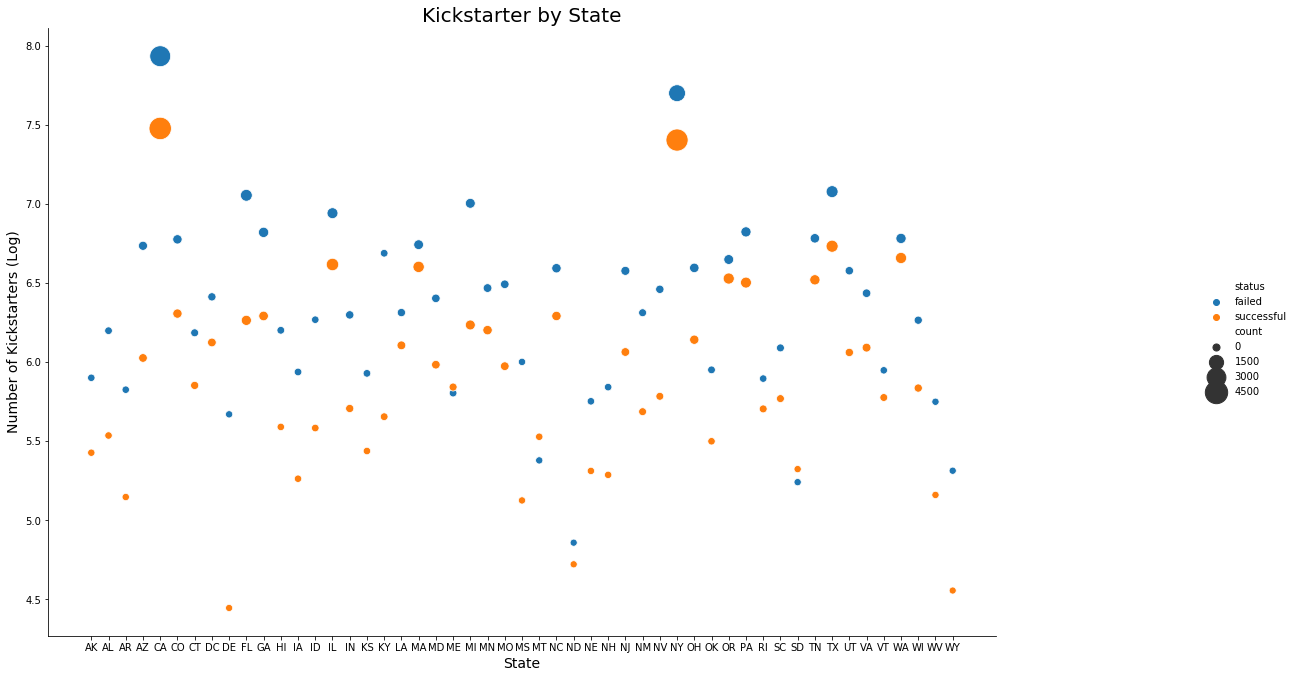

In [45]:
g = sns.relplot(x="state", y='goal_l', size='count', hue='status', sizes=(50, 500), data=df_state)
g.fig.set_size_inches(20, 10)

g.ax.set_title('Kickstarter by State', fontsize=20)
g.set_xlabels('State', fontsize=14)
g.set_ylabels('Number of Kickstarters (Log)', fontsize=14)

Text(0, 0.5, 'Number of Kickstarters')

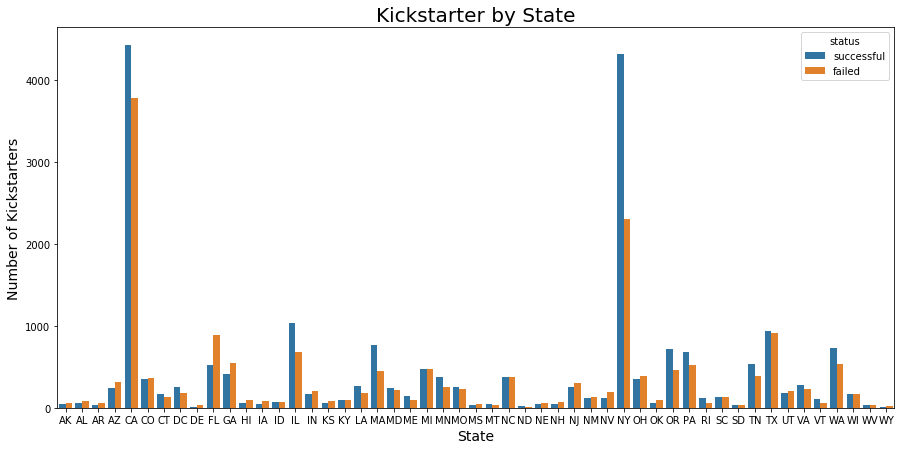

In [46]:
plt.figure(figsize=(15,7))
ax = plt.gca()
g = sns.barplot(ax=ax, x="state", y='count', hue='status', hue_order=['successful', 'failed'], data=df_state)

g.set_title('Kickstarter by State', fontsize=20)
g.set_xlabel('State', fontsize=14)
g.set_ylabel('Number of Kickstarters', fontsize=14)

## 1.7 Goal and Pledge Distribution (Aggregated by State)

/home/neil/anaconda3/envs/Luumit/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


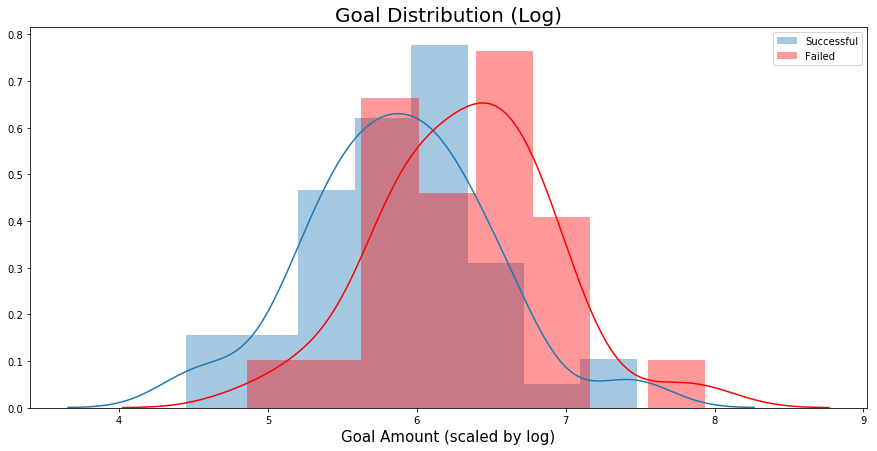

In [47]:
plt.figure(figsize=(15,7))
g = sns.distplot(df_state[df_state['status']=='successful']['goal_l'], axlabel='Kickstarter Goal')
g = sns.distplot(df_state[df_state['status']=='failed']['goal_l'], color='r', axlabel='Kickstarter Goal')

g.set_title('Goal Distribution (Log)', fontsize=20)
g.set_xlabel('Goal Amount (scaled by log)', fontsize=15)
g.legend(['Successful', 'Failed'])

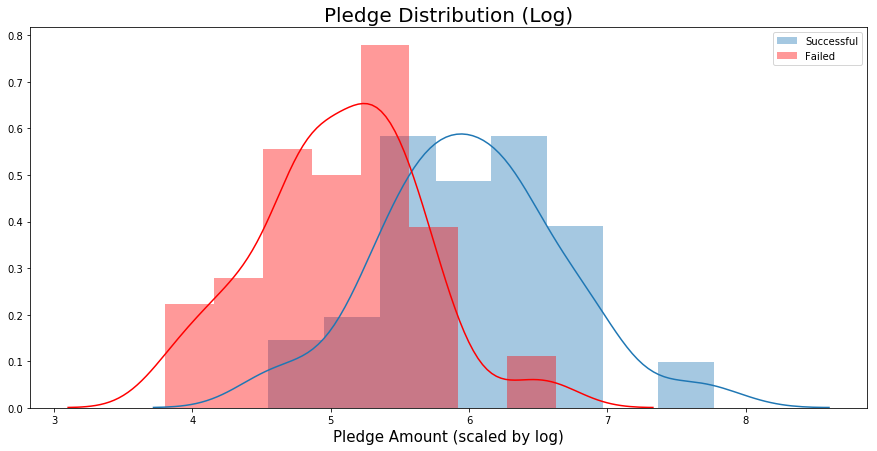

In [48]:
plt.figure(figsize=(15,7))
g = sns.distplot(df_state[df_state['status']=='successful']['pledged_l'], axlabel='Kickstarter Goal')
g = sns.distplot(df_state[df_state['status']=='failed']['pledged_l'], color='r', axlabel='Kickstarter Goal')

g.set_title('Pledge Distribution (Log)', fontsize=20)
g.set_xlabel('Pledge Amount (scaled by log)', fontsize=15)
g.legend(['Successful', 'Failed'])

In [49]:
df['funded date'] = pd.to_datetime(df['funded date'])

df['funded_year'] = df['funded date'].apply(lambda date: date.year)
df['funded_month'] = df['funded date'].apply(lambda date: date.month)

df.drop(axis=1, columns=['funded date'], inplace=True)

/home/neil/anaconda3/envs/Luumit/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/neil/anaconda3/envs/Luumit/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/neil/anaconda3/envs/Luumit/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

In [50]:
df.sample().T

,41119
project id,1928497546
name,Weaving Monk's New Line from the Oregon Woods
url,http://www.kickstarter.com/projects/weavingmon...
category,Design
subcategory,Crafts
status,successful
goal,5000
pledged,5395
funded percentage,1.079
backers,53


In [51]:
df['levels'].describe()

count    38463.000000
mean         7.995866
std          4.211142
min          1.000000
25%          5.000000
50%          7.000000
75%         10.000000
max         80.000000
Name: levels, dtype: float64

In [ ]:
# Fix the Film &amp; Video category and merge with Film & Video
df['reward levels'].replace(to_replace='\$', value='', inplace=True, regex=True)

## 2. Data Preparation

In [ ]:
columns = df.columns.values.tolist()
columns.remove('status')

# URL will be used at a later stage during web scraping
columns.remove('url') 

# Remove Pledge and Pledge Percentage to reduce colinearity and leakage (Pledged Amount)
columns.remove('pledged')
columns.remove('funded percentage')

# Remove other columns as well
columns.remove('country')

In [ ]:
columns

In [ ]:
x = df[columns]
x = x.set_index('project id')
y = df['status'].values

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state=42, shuffle=True)

In [ ]:
y_lr_train, y_lr_test = train_test_split(df['pledged'], test_size = 0.1, random_state=42, shuffle=True)

In [ ]:
ohe = OneHotEncoder(handle_unknown='ignore')
x_train = ohe.fit_transform(x_train)
x_test = ohe.transform(x_test)

# 3. Modeling

In [ ]:
# Global Variables
TRAIN_RATIO = 0.90
TEST_RATIO = 0.10

RANDOM_STATE = 42
VERBOSE = 1
N_JOBS = -1

CV = 10
ITERATIONS = 1000
N_ESTIMATORS = 200

# 3.1 Pledged Funding

## 3.1.1 Linear Regression

In [ ]:
lr = LinearRegression(fit_intercept=True, normalize=True, n_jobs=N_JOBS)

In [ ]:
lr.fit(x_train, y_lr_train.values)

In [ ]:
lr.score(x_test, y_lr_test.values)

## 3.1.2 Random Forest Regression

In [ ]:
rfr = RandomForestRegressor(n_estimators=N_ESTIMATORS, n_jobs=N_JOBS, verbose=VERBOSE, random_state=RANDOM_STATE)

In [ ]:
rfr.fit(x_train, y_lr_train)

In [ ]:
rfr.score(x_test, y_lr_test)

#### Score is a bit low, let's try to model for each category instead

## 3.1.3 Linear Regression per Category

In [ ]:
for category in CATEGORIES:
    df_sub = df[df['category'] == category]
    x = df_sub[columns]
    x = x.set_index('project id')
    y = df_sub['pledged'].values
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = TEST_RATIO, random_state=42, shuffle=True)
    
    ohe = OneHotEncoder(handle_unknown='ignore')
    x_train = ohe.fit_transform(x_train)
    x_test = ohe.transform(x_test)
    
    lr = LinearRegression(fit_intercept=True, normalize=True, n_jobs=N_JOBS)
    lr.fit(x_train, y_train)
    print(category, lr.score(x_test, y_test))

In [ ]:
for category in CATEGORIES:
    df_sub = df[df['category'] == category]
    x = df_sub[columns]
    x = x.set_index('project id')
    y = df_sub['pledged'].values
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state=42, shuffle=True)
    
    ohe = OneHotEncoder(handle_unknown='ignore')
    x_train = ohe.fit_transform(x_train)
    x_test = ohe.transform(x_test)
    
    rfr = RandomForestRegressor(n_estimators=N_ESTIMATORS, n_jobs=N_JOBS, verbose=VERBOSE, random_state=RANDOM_STATE)
    rfr.fit(x_train, y_train)
    print(category, rfr.score(x_test, y_test))

In [ ]:
for category in CATEGORIES:
    df_sub = df[df['category'] == category]
    x = df_sub[columns]
    x = x.set_index('project id')
    y = df_sub['pledged'].values
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state=42, shuffle=True)
    
    ohe = OneHotEncoder(handle_unknown='ignore')
    x_train = ohe.fit_transform(x_train)
    x_test = ohe.transform(x_test)
    
    lcv = LassoCV(n_jobs=N_JOBS, random_state=RANDOM_STATE)
    lcv.fit(x_train, y_train)
    print(category,lcv.score(x_test, y_test))

# 3.2 Success or Failed Prediction

## 3.2.1 Logistic Regression

In [ ]:
lrcv = LogisticRegressionCV(cv=CV, max_iter=ITERATIONS, verbose=VERBOSE, random_state=RANDOM_STATE, n_jobs=N_JOBS)

In [ ]:
lrcv.fit(x_train, y_train)

In [ ]:
lrcv.score(x_test, y_test)

In [ ]:
confusion_matrix(y_test, lrcv.predict(x_test))

In [ ]:
print(classification_report(y_test, lrcv.predict(x_test)))

In [ ]:
ohe.get_feature_names()

In [ ]:
lrcv.coef_[0]

## 3.2.2 Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE, verbose=VERBOSE, n_jobs=N_JOBS)

In [ ]:
rf.fit(x_train, y_train)

In [ ]:
rf.score(x_test, y_test)

In [ ]:
cross_val_score(RandomForestClassifier(n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE, verbose=VERBOSE, n_jobs=N_JOBS), 
                x_train, y_train, cv=CV, verbose=1)

In [ ]:
confusion_matrix(y_test, rf.predict(x_test))

In [ ]:
print(classification_report(y_test, rf.predict(x_test)))